In [1]:
import pandas as pd
import os
import numpy as np
import statistics
from scipy.stats import ttest_ind
from scipy.stats import gmean
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from pySankey.sankey import sankey
import plotly.graph_objects as go

os.chdir("./../..")
print(os.getcwd())

SAVE_FOLDER = "data/output/cognitive_shift_data"

c:\Users\rapha\EPFL\ADA\ada-2024-project-theadacuates


# Load data

In [2]:
df_paths = pd.read_csv("data/output/processed_data/paths_processed.csv")

df_paths['path'] = df_paths['path'].str.split(';')

cols_to_convert = ["path_list", "path_list_id", "resolved_path_list_id", "resolved_path_list_name"]

for col in cols_to_convert:
    df_paths[col] = df_paths[col].apply(ast.literal_eval)

df_names = pd.read_csv("data/output/processed_data/articles_processed.csv")

df_paths.head(2)

C:\Users\rapha\AppData\Local\Temp\ipykernel_11556\3622011664.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_paths = pd.read_csv("data/output/processed_data/paths_processed.csv")


,hashed_ip,timestamp,duration,path,rating,path_list,source_link,target_link,finished,type_unfinished,n_click,n_back,date,click_rate,normalized_duration,freq_back,path_list_id,resolved_path_list_id,resolved_path_list_name
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,"[14th century, 15th century, 16th century, Pac...",14th century,African slave trade,True,NaN,9,0,2011-02-15 04:26:49,0.054217,18.444444,0.0,"[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[14th century, 15th century, 16th century, Pac..."
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,"[14th century, Europe, Africa, Atlantic slave ...",14th century,African slave trade,True,NaN,5,0,2012-08-12 08:36:52,0.056818,17.600000,0.0,"[10, 1433, 128, 379, 143]","[10, 1433, 128, 379, 143]","[14th century, Europe, Africa, Atlantic slave ..."


# Cognitive shift

Moving from one category of knowledge to another (e.g., from science-related articles to arts-related articles) requires cognitive shifting, which can increase cognitive load. Cognitive shifting is known to engage the executive function of the brain and may lead to errors or abandonment if the shift is too taxing. We will first analyse shift of category along a path, and then look at semantic shift.

In [3]:
df_cat = pd.read_csv("data/output/processed_data/categories_processed.csv")

df_cat = df_cat[["article_name", "article_category_1"]]

# dictionary mapping article to its main category
article_to_category = dict(zip(df_cat["article_name"], df_cat["article_category_1"]))

def map_articles_to_categories(article_list):
    #print(article_list)
    article_list =  article_list
    list_cat = []
    for article in article_list:
        #print(article)
        list_cat.append(article_to_category.get(article, "Unknown"))
    return list_cat

df_paths["resolved_path_list_category"] = df_paths["resolved_path_list_name"].apply(map_articles_to_categories)

df_paths["resolved_path_list_category"]

0        [History, History, History, Geography, Geograp...
1        [History, Geography, Geography, History, History]
2        [History, Geography, Geography, History, Citiz...
3                   [History, History, History, Countries]
4        [History, Countries, Religion, Science, People...
                               ...                        
74109    [People, Science, Citizenship, Science, Geogra...
74110                                            [History]
74111    [IT, Language and literature, Everyday life, C...
74112             [Geography, Countries, History, History]
74113    [People, Geography, Everyday life, Design and ...
Name: resolved_path_list_category, Length: 74114, dtype: object

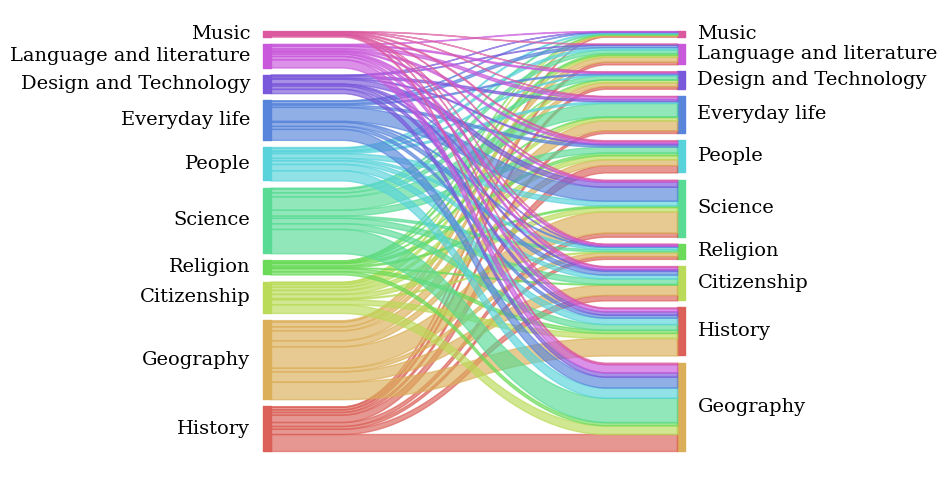

In [4]:
# Find most common categories
cats_sorted = df_cat.groupby("article_category_1").size().sort_values(ascending=False).reset_index()["article_category_1"].to_list()
# Take 10 most common categories
cats_to_use = cats_sorted[:10]

source = []
target = []

for index, row in df_paths.iterrows():
    previous_category = row["resolved_path_list_category"][0]
    for cat in row["resolved_path_list_category"][1:]:
        if cat != previous_category and cat in cats_to_use and previous_category in cats_to_use:
            source.append(previous_category)
            target.append(cat)
            previous_category = cat

sankey(pd.Series(source), pd.Series(target), aspect=20)

In [5]:
# filter out really short paths, no point looking at cognitive shift as path not long enough for it to matter
df_paths = df_paths[df_paths["n_click"] > 3]
# cutoff long paths
df_paths = df_paths[df_paths["n_click"] < 50]

In [6]:
# Create shift metric
def count_category_changes(category_list, finished):
    if not category_list:  # Check if the list is empty
        return 0
    change_count = 0
    for i in range(1, len(category_list)):
        if category_list[i] != category_list[i - 1]:  # Check for a change
            change_count += 1
    # remove last shift for finished paths because it is necessary
    if(finished and change_count > 0):
        change_count -= 1
    return change_count

# Apply the function to each row in the DataFrame
df_paths["category_change_count"] = df_paths.apply(lambda row: count_category_changes(row["resolved_path_list_category"], row["finished"]), axis=1)

print("mean finished:", df_paths[df_paths["finished"] == True]["category_change_count"].mean())
print("median finished:", df_paths[df_paths["finished"] == True]["category_change_count"].median())
print("geometric mean finished:", gmean(df_paths[df_paths["finished"] == True]["category_change_count"].apply(lambda x: x + 1).tolist()) - 1)

print("mean unfinished: ", df_paths[df_paths["finished"] == False]["category_change_count"].mean())
print("median unfinished: ", df_paths[df_paths["finished"] == False]["category_change_count"].median())
print("geometric mean unfinished: ", gmean(df_paths[df_paths["finished"] == False]["category_change_count"].apply(lambda x: x + 1).tolist()) - 1)


df_paths.head(2)

mean finished: 2.5519038502446287
median finished: 2.0
geometric mean finished: 1.9240359772912567
mean unfinished:  4.196672967863894
median unfinished:  3.0
geometric mean unfinished:  3.378821637182205


,hashed_ip,timestamp,duration,path,rating,path_list,source_link,target_link,finished,type_unfinished,...,n_back,date,click_rate,normalized_duration,freq_back,path_list_id,resolved_path_list_id,resolved_path_list_name,resolved_path_list_category,category_change_count
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,"[14th century, 15th century, 16th century, Pac...",14th century,African slave trade,True,NaN,...,0,2011-02-15 04:26:49,0.054217,18.444444,0.0,"[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[14th century, 15th century, 16th century, Pac...","[History, History, History, Geography, Geograp...",1
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,"[14th century, Europe, Africa, Atlantic slave ...",14th century,African slave trade,True,NaN,...,0,2012-08-12 08:36:52,0.056818,17.600000,0.0,"[10, 1433, 128, 379, 143]","[10, 1433, 128, 379, 143]","[14th century, Europe, Africa, Atlantic slave ...","[History, Geography, Geography, History, History]",1


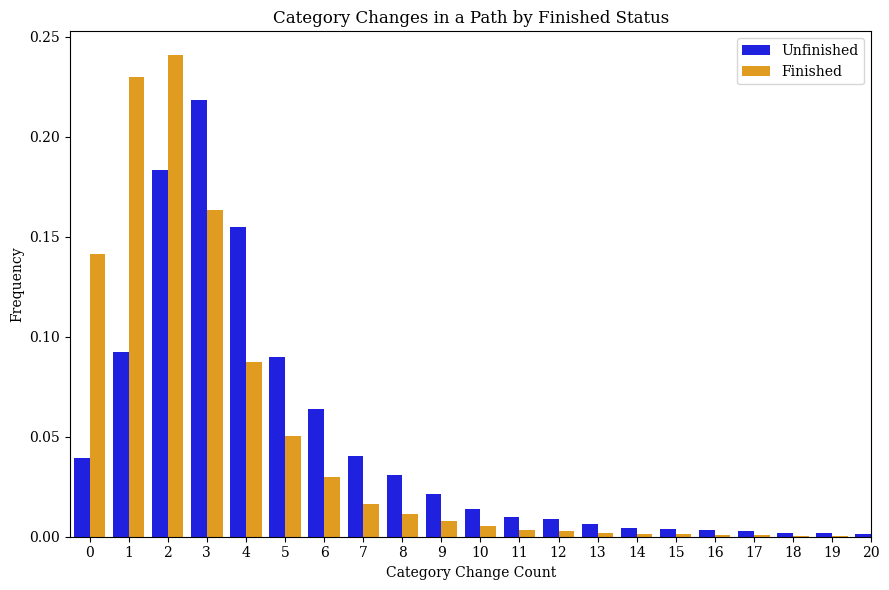

In [7]:
# Group by 'finished' and 'category_change_count' to count occurrences
df_paths_finished = df_paths[df_paths["finished"] == True]
df_paths_unfinished = df_paths[df_paths["finished"] == False]

finished_frequency = df_paths_finished.groupby(['category_change_count']).size().reset_index(name = "freq")
finished_frequency["freq"] = finished_frequency["freq"] / df_paths_finished.shape[0]
finished_frequency["finished"] = True

unfinished_frequency = df_paths_unfinished.groupby(['category_change_count']).size().reset_index(name = "freq")
unfinished_frequency["freq"] = unfinished_frequency["freq"] / df_paths_unfinished.shape[0]
unfinished_frequency["finished"] = False

combined_freq = pd.concat([finished_frequency, unfinished_frequency])

# Create the bar plot
plt.figure(figsize=(9, 6))
g = sns.barplot(data=combined_freq, x='category_change_count', y='freq', hue='finished', palette={True: "orange", False: "blue"})
g.legend_.set_title(None)
# replace labels
new_labels = ['Unfinished', 'Finished']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

# #Customize the plot
plt.title("Category Changes in a Path by Finished Status")
plt.xlabel("Category Change Count")
plt.ylabel("Frequency")
plt.xlim(right = 20)
plt.tight_layout()
plt.show()

Maybe splitting change count by path length is a bit more informative.

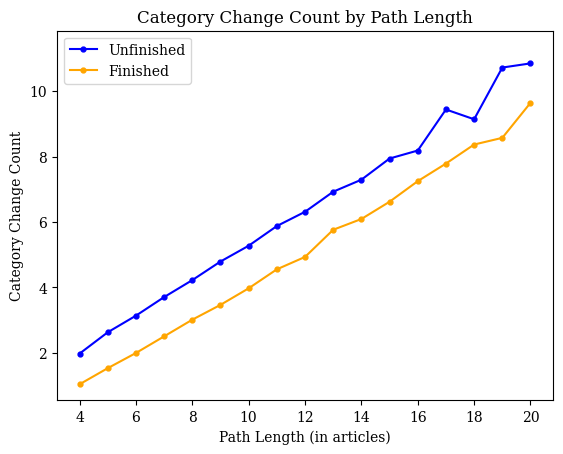

In [8]:
max_x = 20

df_paths_finished = df_paths_finished[df_paths_finished["n_click"] <= max_x]
df_paths_unfinished = df_paths_unfinished[df_paths_unfinished["n_click"] <= max_x]

finished_category_change = df_paths_finished.groupby("n_click")["category_change_count"].mean().reset_index()
unfinished_category_change = df_paths_unfinished.groupby("n_click")["category_change_count"].mean().reset_index()

plt.plot(unfinished_category_change["n_click"], unfinished_category_change["category_change_count"], marker = ".", markersize = 7, label="Unfinished", color="blue")
plt.plot(finished_category_change["n_click"], finished_category_change["category_change_count"], marker = ".", markersize = 7, label="Finished", color="orange")

plt.ylim(None, max(finished_category_change["category_change_count"].max(), unfinished_category_change["category_change_count"].max()) + 1)

plt.title("Category Change Count by Path Length")
plt.xlabel("Path Length (in articles)")
plt.ylabel("Category Change Count")

plt.legend()
plt.show()

In [9]:
df_paths.to_csv(os.path.join(SAVE_FOLDER, "paths_category_shift.csv"), index = False)

In [10]:
finished_counts = df_paths[df_paths["finished"] == True]["category_change_count"]
not_finished_counts = df_paths[df_paths["finished"] == False]["category_change_count"]

t_stat, p_value = ttest_ind(finished_counts, not_finished_counts, equal_var=False)  # Use Welch's t-test

alpha = 0.05  # Significance level
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means of the two groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means of the two groups.")

T-statistic: -50.690
P-value: 0.000
Reject the null hypothesis: There is a significant difference between the means of the two groups.


### Conclusion

The category shift per path is quite higher in unfinished paths. However category shift might not be the best way to measure cognitive load as even if two articles do not have the same category, they could still be very closely related, and vice versa. Take for example ... .

## Semantic shift

Instead of looking at the shift in article category, we will try looking at the semantic shift between articles. This is calculated by taking one minus the semantic similarity between two successive articles, giving us the semantic shift between the two articles. Large semantic shifts between articles can represent a higher cognitive load for the player, having to completely change topics from one article to the other. We will try to analyse this semantic shift along paths to see if this can have an impact on whether the path is finished or not.

We will use SentenceTransmormer, which embeds text to multidimensional vectors that can then be compared by taking the "angle" between two vectors.

In [11]:
from sentence_transformers import SentenceTransformer

# model = SentenceTransformer("all-MiniLM-L6-v2")
model = SentenceTransformer("multi-qa-mpnet-base-dot-v1") # best model for semantic similarity, but also much slower

model.similarity_fn_name = "cosine" # valid options are “cosine”, “dot”, “euclidean”, and "manhattan"

c:\Users\rapha\anaconda3\envs\ada\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# reload data, we filtered some rows out before
df_paths = pd.read_csv("data/output/processed_data/paths_processed.csv")

df_paths['path'] = df_paths['path'].str.split(';')

cols_to_convert = ["path_list", "path_list_id", "resolved_path_list_id", "resolved_path_list_name"]

for col in cols_to_convert:
    df_paths[col] = df_paths[col].apply(ast.literal_eval)

df_paths.head(2)

C:\Users\rapha\AppData\Local\Temp\ipykernel_11556\1866733180.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_paths = pd.read_csv("data/output/processed_data/paths_processed.csv")


,hashed_ip,timestamp,duration,path,rating,path_list,source_link,target_link,finished,type_unfinished,n_click,n_back,date,click_rate,normalized_duration,freq_back,path_list_id,resolved_path_list_id,resolved_path_list_name
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,"[14th century, 15th century, 16th century, Pac...",14th century,African slave trade,True,NaN,9,0,2011-02-15 04:26:49,0.054217,18.444444,0.0,"[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[14th century, 15th century, 16th century, Pac..."
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,"[14th century, Europe, Africa, Atlantic slave ...",14th century,African slave trade,True,NaN,5,0,2012-08-12 08:36:52,0.056818,17.600000,0.0,"[10, 1433, 128, 379, 143]","[10, 1433, 128, 379, 143]","[14th century, Europe, Africa, Atlantic slave ..."


This is an example to show the semantic similarity at work. The results obtained are about what one could expect, William Shakespeare being semantically close to playwright and Romeo and Juliet, but having nothing to do with Data analysis. This isn't perfect as it struggles with more complex relationships such as between "Romeo and Juliet" and "love" which one could expect to be closely related.

,William Shakespeare,playwright,Romeo and Juliet,17th century,love,Data analysis
William Shakespeare,1.000000,0.656702,0.681668,0.433091,0.441500,0.299462
playwright,0.656702,1.000000,0.495177,0.315922,0.314569,0.269010
Romeo and Juliet,0.681668,0.495177,1.000000,0.430731,0.521815,0.322213
17th century,0.433091,0.315922,0.430731,1.000000,0.364583,0.382337
love,0.441500,0.314569,0.521815,0.364583,1.000000,0.380129
Data analysis,0.299462,0.269010,0.322213,0.382337,0.380129,1.000000


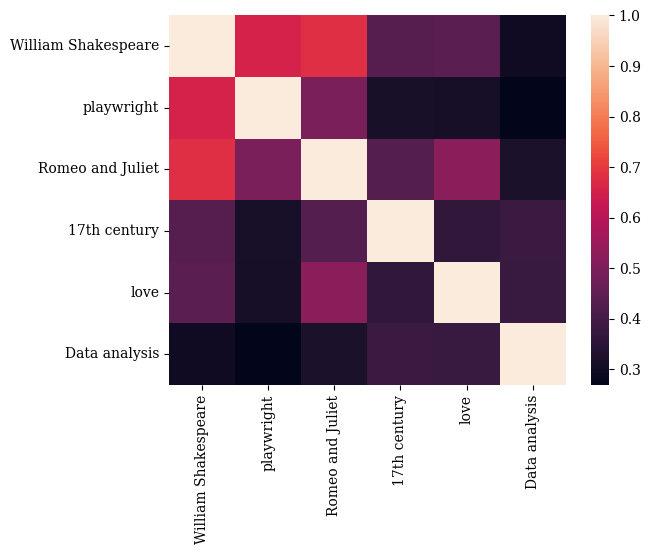

In [13]:
examples1 = ["William Shakespeare", "playwright", "Romeo and Juliet", "17th century", "love", "Data analysis"]
embeddings1 = model.encode(examples1)

similarities = model.similarity(embeddings1, embeddings1)
similarities = pd.DataFrame(similarities)
similarities.columns = examples1
similarities.index = examples1
display(similarities)

similarities.to_csv(os.path.join(SAVE_FOLDER, "example_similarity.csv"))

sns.heatmap(similarities)
plt.show()

In [14]:
def clamp(n, min, max): 
    if n < min: 
        return min
    elif n > max: 
        return max
    else: 
        return n 

# if simmilarity matrix doesn't exist, make it
if not os.path.exists(os.path.join(SAVE_FOLDER, "semantic_similarity_matrix.csv")):
    # encode all articles to then perform comparison
    embeddings = model.encode(df_names["article_name"])
    num_articles = len(embeddings)
    matrix = np.zeros(shape=(num_articles, num_articles))

    for i in range (0, num_articles):
        similarities = model.similarity(np.array([embeddings[i]]), embeddings[0:(i+1)])[0]
        # populate matrix
        for j in range(0, i+1):
            # similarities should always be between 0 and 1
            similarity = clamp(similarities[j], 0, 1)
            # similarity matrix is symmetric
            matrix[i][j] = similarity
            matrix[j][i] = similarity

    matrix = pd.DataFrame(matrix, index = df_names["article_name"], columns=df_names["article_name"])
    matrix.to_csv(os.path.join(SAVE_FOLDER, "semantic_similarity_matrix.csv"))

similarity_matrix = pd.read_csv(os.path.join(SAVE_FOLDER, "semantic_similarity_matrix.csv"), sep=',', header=0, comment='#', index_col="article_name")
display(similarity_matrix)

def SemanticSimilarity(article_from, article_to):
    try:
        return similarity_matrix[article_from][article_to]
    except:
        print("Cannot find simlarity between", article_from, "and", article_to)
        return np.nan

,Áedán mac Gabráin,Åland,Édouard Manet,Éire,Óengus I of the Picts,€2 commemorative coins,10th century,11th century,12th century,13th century,...,Ziad Jarrah,Zimbabwe,Zinc,Zinc chloride,Zion National Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
article_name,,,,,,,,,,,,,,,,,,,,,
Áedán mac Gabráin,1.000000,0.427910,0.237402,0.373486,0.300793,0.207649,0.268425,0.313857,0.250295,0.223370,...,0.398687,0.309459,0.305722,0.267938,0.286943,0.261845,0.452439,0.318833,0.374517,0.304350
Åland,0.427910,1.000000,0.377768,0.348431,0.322486,0.200049,0.301942,0.330844,0.274256,0.292470,...,0.385005,0.221507,0.293485,0.278389,0.277878,0.322565,0.292526,0.248917,0.348639,0.285108
Édouard Manet,0.237402,0.377768,1.000000,0.345499,0.381082,0.290567,0.253936,0.289308,0.321045,0.359289,...,0.412350,0.256791,0.260005,0.262387,0.292830,0.362200,0.224617,0.339343,0.311622,0.286998
Éire,0.373486,0.348431,0.345499,1.000000,0.312589,0.280968,0.262231,0.356952,0.327935,0.300746,...,0.303992,0.300092,0.282531,0.291870,0.217504,0.287560,0.323970,0.353225,0.317288,0.234413
Óengus I of the Picts,0.300793,0.322486,0.381082,0.312589,1.000000,0.264701,0.337953,0.336878,0.294056,0.318663,...,0.318713,0.265690,0.291051,0.250273,0.291052,0.293739,0.296906,0.339685,0.377326,0.234867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zionism,0.261845,0.322565,0.362200,0.287560,0.293739,0.202146,0.357604,0.275553,0.274251,0.263785,...,0.526050,0.415523,0.398721,0.374219,0.684156,1.000000,0.358565,0.460266,0.307906,0.333167
Zirconium,0.452439,0.292526,0.224617,0.323970,0.296906,0.288489,0.304370,0.265565,0.214234,0.170499,...,0.436689,0.414908,0.575800,0.556320,0.339254,0.358565,1.000000,0.533747,0.405895,0.274458
Zoroaster,0.318833,0.248917,0.339343,0.353225,0.339685,0.206020,0.378560,0.319335,0.284972,0.254555,...,0.532021,0.429986,0.484049,0.416203,0.396868,0.460266,0.533747,1.000000,0.333262,0.306034


In [15]:
def CreateSemanticShiftList(row, remove_target = False):
    path_list = row.resolved_path_list_name
    if(remove_target and row["finished"]):
        path_list = path_list[:-1]
    semantic_shift_list = []

    for i in range(len(path_list) - 1):
        semantic_similarity = SemanticSimilarity(path_list[i], path_list[i+1])
        # we want the shift, how different the two articles so take 1 - similarity
        semantic_shift_list.append(1 - semantic_similarity)
    
    return semantic_shift_list

df_paths["path_semantic_shift"] = df_paths.apply(lambda row: CreateSemanticShiftList(row), axis = 1)
df_paths["average_semantic_shift"] = df_paths["path_semantic_shift"].apply(lambda path: statistics.mean(path) if len(path) > 1 else np.nan)

# get all semantic shifts in lists
mean_semantic_shift_pf = df_paths[df_paths["finished"] == True]["average_semantic_shift"]
mean_semantic_shift_pf = [x for x in mean_semantic_shift_pf if ~np.isnan(x)]

mean_semantic_shift_uf = df_paths[df_paths["finished"] == False]["average_semantic_shift"]
mean_semantic_shift_uf = [x for x in mean_semantic_shift_uf if ~np.isnan(x)]

mean_finished = statistics.mean(mean_semantic_shift_pf)
mean_unfinished = statistics.mean(mean_semantic_shift_uf)

print(f"Semantic shift (finished paths): mean = {mean_finished:.4f} median = {statistics.median(mean_semantic_shift_pf):.4f}")
print(f"Semantic shift (unfinished paths): mean = {mean_unfinished:.4f} median = {statistics.median(mean_semantic_shift_uf):.4f}")
pval = ttest_ind(mean_semantic_shift_pf, mean_semantic_shift_uf).pvalue
print("P-value = {} so the semantic shift between finished and unfinished paths is statistically different".format(pval))

Semantic shift (finished paths): mean = 0.5030 median = 0.5040
Semantic shift (unfinished paths): mean = 0.5171 median = 0.5179
P-value = 8.395755957977429e-97 so the semantic shift between finished and unfinished paths is statistically different


In [16]:
# # plot histogram
# plt.figure(figsize=(9, 5))
# g = sns.histplot(data=df_paths, x="average_semantic_shift", hue="finished", multiple="layer", binwidth=0.02, binrange=[0,1], stat="proportion", common_norm = False, alpha=0.7, edgecolor='white')

# g.legend_.set_title(None)
# # replace labels
# new_labels = ['Unfinished', 'Finished', f'Mean Finished ({mean_finished:.2f})', f'Mean Uninished ({mean_unfinished:.2f})']
# for t, l in zip(g.legend_.texts, new_labels):
#     t.set_text(l)

# plt.title("Semantic shift of finished vs unfinished paths")
# plt.xlabel("Average semantic shift of path")
# plt.axvline(np.mean(mean_semantic_shift_pf), color='orange', linestyle='dashed', linewidth=2, label='Mean Finished')
# plt.axvline(np.mean(mean_semantic_shift_uf), color='blue', linestyle='dashed', linewidth=2, label='Mean Unfinished')
# plt.show()

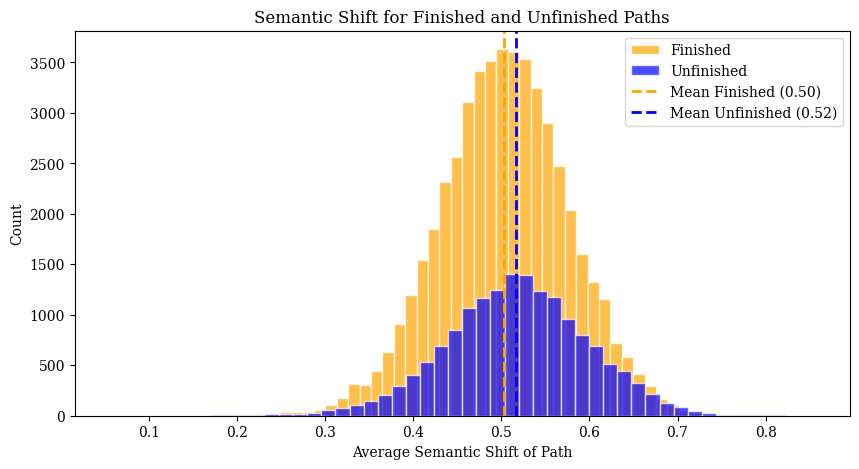

In [17]:
# plot histogram
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_paths[df_paths["finished"] == True]["average_semantic_shift"], color='orange', bins=50, alpha=0.7, label="Finished", edgecolor = "white")
ax.hist(df_paths[df_paths["finished"] == False]["average_semantic_shift"], color='blue', bins=50, alpha=0.7, label="Unfinished", edgecolor = "white")

# mean lines
ax.axvline(statistics.mean(mean_semantic_shift_pf), color='orange', linestyle='dashed', linewidth=2, label=f'Mean Finished ({mean_finished:.2f})')
ax.axvline(statistics.mean(mean_semantic_shift_uf), color='blue', linestyle='dashed', linewidth=2, label=f'Mean Unfinished ({mean_unfinished:.2f})')

ax.set_title("Semantic Shift for Finished and Unfinished Paths")
ax.set_xlabel("Average Semantic Shift of Path")
ax.set_ylabel("Count")

# Display the legend with a cleaner style
ax.legend(frameon=True, loc='upper right')

plt.show()

We can see that semantic shift along finished paths is smaller than for unfinished paths, which means finished paths tend to follow more closely related articles than unfinished paths. The difference is small, as seen by the overall means being close, but still statiscally significant.

## Semantic shift along a path

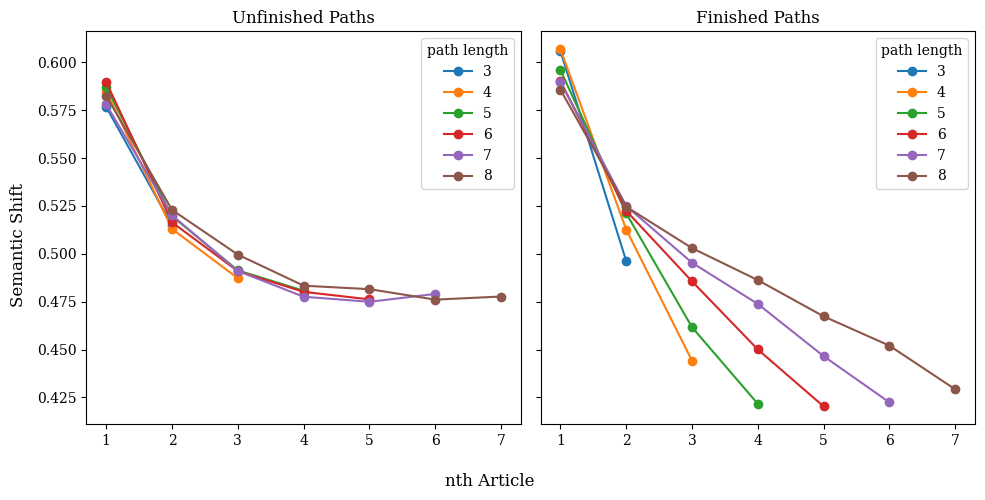

In [18]:
# min/max lengths of paths to include
min_length = 3
max_length = 8

# dfs to store the semantic shifts for each path length
df_uf_shift = pd.DataFrame(index = [x for x in range (min_length, max_length + 1)], columns = [x for x in range (0, max_length)])
df_pf_shift = pd.DataFrame(index = [x for x in range (min_length, max_length + 1)], columns = [x for x in range (0, max_length)])

for length in range (min_length, max_length + 1):
    # get the semantic shift of paths of correct length
    shifts = df_paths.loc[(df_paths["finished"] == False) & (df_paths["n_click"] == length)]["path_semantic_shift"].tolist()
    # compute mean semantic shift for each article position
    shifts = np.nanmean(np.array(shifts), axis=0).tolist()
    # complete with nans to add to df
    shifts += [np.nan] * (max_length + 1 - length)
    df_uf_shift.iloc[length - min_length] = shifts

    shifts = df_paths.loc[(df_paths["finished"] == True) & (df_paths["n_click"] == length)]["path_semantic_shift"].tolist()
    shifts = np.nanmean(np.array(shifts), axis=0).tolist()
    shifts += [np.nan] * (max_length + 1 - length)
    df_pf_shift.iloc[length - min_length] = shifts

df_uf_shift.to_csv(os.path.join(SAVE_FOLDER, "shift_unfinished.csv"))
df_pf_shift.to_csv(os.path.join(SAVE_FOLDER, "shift_finished.csv"))

# display semantic shifts

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.supxlabel("nth Article")
fig.supylabel("Semantic Shift")

df_uf_shift.apply((lambda row: axs[0].plot(df_uf_shift.columns + 1, row, marker = "o", label=row.name)), axis=1)
axs[0].set_title("Unfinished Paths")
axs[0].legend(title="path length", loc = "upper right")
axs[0].xaxis.set_major_locator(plt.MultipleLocator(1))

df_pf_shift.apply((lambda row: axs[1].plot(df_pf_shift.columns + 1, row, marker = "o", label=row.name)), axis=1)
axs[1].set_title("Finished Paths")
axs[1].legend(title="path length", loc = "upper right")
axs[1].xaxis.set_major_locator(plt.MultipleLocator(1))

fig.tight_layout()

We see that the semantic shift decreases at the end of finished paths compared to unfinished paths which stagnate. We can hypothesise that this is due to the fact that at the end of finished paths, the player typically refines his search to get to his target. This leads to a smaller semantic shift towards the last couple of articles as the topics are now more closely related to the target, so less shift between successive article. This would explain why the average semantic shift is lower for finished paths.

In [19]:
def CreateSemanticSimilarityList(row):
    path_list = row.resolved_path_list_name
    similarity_list = []

    for article in path_list:
        similarity = SemanticSimilarity(article, row.target_link)
    
        similarity_list.append(similarity)
    
    return similarity_list

df_paths["path_similarity"] = df_paths.apply(lambda row: CreateSemanticSimilarityList(row), axis = 1)
df_paths["average_similarity"] = df_paths["path_similarity"].apply(lambda path: statistics.mean(path) if len(path) > 0 else np.nan)


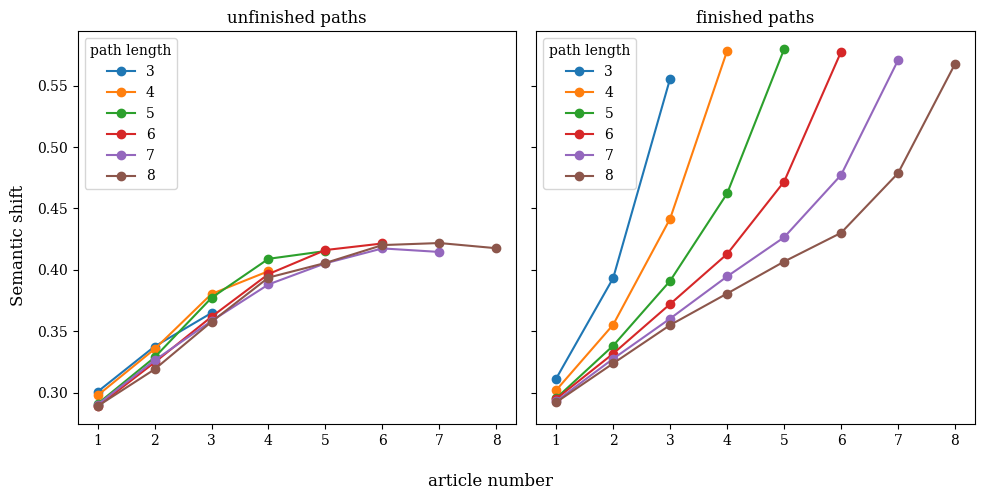

In [20]:
min_length = 3
max_length = 8

df_uf_similarity = pd.DataFrame(index = [x for x in range (min_length, max_length + 1)], columns = [x for x in range (0, max_length)])
df_pf_similarity = pd.DataFrame(index = [x for x in range (min_length, max_length + 1)], columns = [x for x in range (0, max_length)])

for length in range (min_length, max_length + 1):
    # get the semantic shift of paths of correct length
    similarities = df_paths.loc[(df_paths["finished"] == False) & (df_paths["n_click"] == length)]["path_similarity"].tolist()
    # compute mean semantic similarity for each article position
    similarities = np.nanmean(np.array(similarities), axis=0).tolist()
    # complete with nans to add to df
    similarities += [np.nan] * (max_length - length)
    df_uf_similarity.iloc[length - min_length] = similarities

    similarities = df_paths.loc[(df_paths["finished"] == True) & (df_paths["n_click"] == length + 1)]["path_similarity"].tolist()
    # remove last node, always max semantic similarity because reached target
    similarities = [x[:-1] for x in similarities]
    similarities = np.nanmean(np.array(similarities), axis=0).tolist()
    similarities += [np.nan] * (max_length - length)
    df_pf_similarity.iloc[length - min_length] = similarities

df_uf_similarity.to_csv(os.path.join(SAVE_FOLDER, "similarity_unfinished.csv"))
df_pf_similarity.to_csv(os.path.join(SAVE_FOLDER, "similarity_finished.csv"))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.supxlabel("article number")
fig.supylabel("Semantic shift")

df_uf_similarity.apply((lambda row: axs[0].plot(df_uf_similarity.columns + 1, row, marker = "o", label=row.name)), axis=1)
axs[0].set_title("unfinished paths")
axs[0].legend(title="path length", loc = "upper left")
axs[0].xaxis.set_major_locator(plt.MultipleLocator(1))

df_pf_similarity.apply((lambda row: axs[1].plot(df_pf_similarity.columns + 1, row, marker = "o", label=row.name)), axis=1)
axs[1].set_title("finished paths")
axs[1].legend(title="path length", loc = "upper left")
axs[1].xaxis.set_major_locator(plt.MultipleLocator(1))

fig.tight_layout()

Looking at the semantic similarity to the target along finished and unfinished paths supports our previous hypothesis. We can see that there is a drastic jump in semantic similarity to the target in the last couple of articles for finished paths.

In [21]:
df_paths["path_semantic_shift_2"] = df_paths.apply(lambda row: CreateSemanticShiftList(row, True), axis = 1)
df_paths["average_semantic_shift_2"] = df_paths["path_semantic_shift_2"].apply(lambda path: statistics.mean(path) if len(path) > 1 else np.nan)

mean_semantic_shift_pf = df_paths[df_paths["finished"] == True]["average_semantic_shift_2"]
mean_semantic_shift_pf = [x for x in mean_semantic_shift_pf if ~np.isnan(x)]

mean_semantic_shift_uf = df_paths[df_paths["finished"] == False]["average_semantic_shift_2"]
mean_semantic_shift_uf = [x for x in mean_semantic_shift_uf if ~np.isnan(x)]

mean_finished = statistics.mean(mean_semantic_shift_pf)
mean_unfinished = statistics.mean(mean_semantic_shift_uf)

print(f"Semantic shift (finished paths): mean = {mean_finished:.4f} median = {statistics.median(mean_semantic_shift_pf):.4f}")
print(f"Semantic shift (unfinished paths): mean = {mean_unfinished:.4f} median = {statistics.median(mean_semantic_shift_uf):.4f}")
pval = ttest_ind(mean_semantic_shift_pf, mean_semantic_shift_uf).pvalue
print("P-value = {} so the semantic shift between finished and unfinished paths is statistically different".format(pval))

Semantic shift (finished paths): mean = 0.5195 median = 0.5200
Semantic shift (unfinished paths): mean = 0.5171 median = 0.5179
P-value = 0.0007380985405076479 so the semantic shift between finished and unfinished paths is statistically different


In [22]:
# plt.figure(figsize=(9, 6))
# g = sns.histplot(data=df_paths, x="average_semantic_shift_2", hue="finished", multiple="layer", binwidth=0.02, binrange=[0,1], stat="proportion", common_norm = False, alpha=0.7, edgecolor='white')
# g.legend_.set_title(None)
# # replace labels
# new_labels = ['Unfinished', 'Finished']
# for t, l in zip(g.legend_.texts, new_labels):
#     t.set_text(l)
# plt.title("Semantic shift of a path for finished vs unfinished paths")
# plt.xlabel("Average semantic shift of path")
# plt.axvline(statistics.mean(mean_semantic_shift_pf), color='orange', linestyle='dashed', linewidth=2, label='Mean Finished')
# plt.axvline(statistics.mean(mean_semantic_shift_uf), color='blue', linestyle='dashed', linewidth=2, label='Mean Unfinished')
# plt.show()

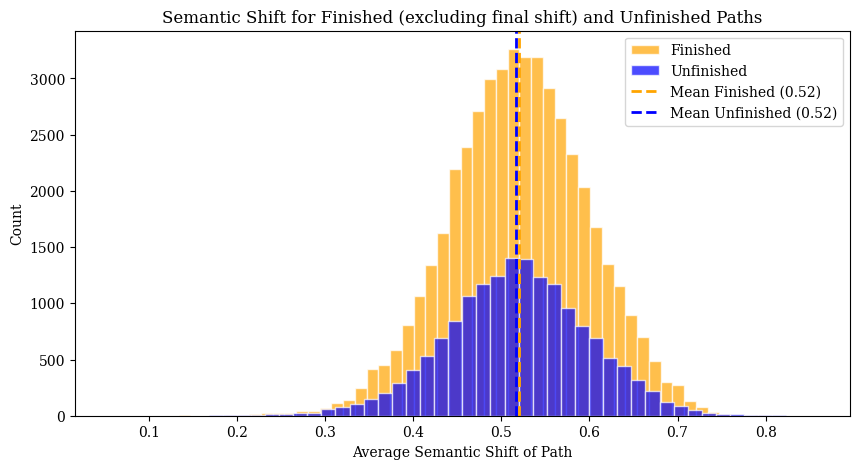

In [23]:
# plot histogram
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_paths[df_paths["finished"] == True]["average_semantic_shift_2"], color='orange', bins=50, alpha=0.7, label="Finished", edgecolor = "white")
ax.hist(df_paths[df_paths["finished"] == False]["average_semantic_shift_2"], color='blue', bins=50, alpha=0.7, label="Unfinished", edgecolor = "white")

# mean lines
ax.axvline(statistics.mean(mean_semantic_shift_pf), color='orange', linestyle='dashed', linewidth=2, label=f'Mean Finished ({mean_finished:.2f})')
ax.axvline(statistics.mean(mean_semantic_shift_uf), color='blue', linestyle='dashed', linewidth=2, label=f'Mean Unfinished ({mean_unfinished:.2f})')

ax.set_title("Semantic Shift for Finished (excluding final shift) and Unfinished Paths")
ax.set_xlabel("Average Semantic Shift of Path")
ax.set_ylabel("Count")

# Display the legend with a cleaner style
ax.legend(frameon=True, loc='upper right')

plt.show()

We can see that just by removing the final semantic shift for finished paths, the average semantic shift for finished and unfinished paths is almost identical.

## Conclusion

The difference in semantic shift between finished and unfinished paths is small but existant, with finished ones following a semantically closer path. This is largely due to the last couple of articles in finished paths being semantically closer as they all relate to the target article because of the nature of the game. Ignoring the final semantic shift between before last article and target article in finished paths results in a nearly identical average semantic shift for finished and unfinished paths, revealing that it is not a factor of path abandonment.


In [24]:
df_paths.to_csv(os.path.join(SAVE_FOLDER, "paths_semantic_shift.csv"), index = False)